In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12,
})

In [5]:
Mpl = 1.2209e19
GSTAR = 90.0
GSTAR_S = 90.0

# Today
T0_K = 2.7255
eV_per_K = 8.617333262e-5  # eV/K
GeV_per_eV = 1.0e-9
T0 = T0_K * eV_per_K * GeV_per_eV     # GeV
gstar_s0 = 3.91            # today’s entropy d.o.f.
rho_c_over_h2 = 1.05375e-5 # GeV/cm^3
s0 = 2970 #(2.0*np.pi**2/45.0) * gstar_s0 * T0**3  # today's entropy density [GeV^3]

Text(0, 0.5, 'g*')

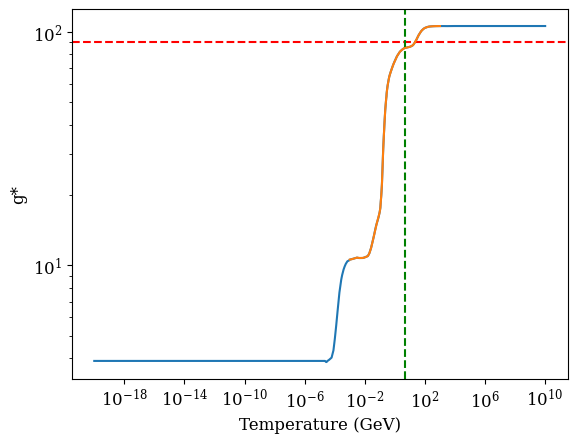

In [49]:
path = "/Users/charlottemyers/projects/ctp/heffBW.dat"
data = np.loadtxt(path)
T_data = data[:,0]
g_eff = data[:,1]

m = 100.0  # DM mass in GeV
#plot
plt.plot(T_data, g_eff)
plt.xscale('log')
plt.yscale('log')
plt.axhline(y=GSTAR, color='r', linestyle='--')
# expected x of freeze out
plt.axvline(x=m/20, color='g', linestyle='--')

# define a function to return gstar at a given T
def gstar_interp(T):
    #if T < T_data.min() or T > T_data.max():
        #return GSTAR
    return np.interp(T, T_data, g_eff)

# plot outputs
T_test = np.logspace(-3, 3, 1000)
gstar_test = [gstar_interp(T) for T in T_test]
plt.plot(T_test, gstar_test, label='Interpolated g*')
plt.xlabel('Temperature (GeV)')
plt.ylabel('g*')

In [ ]:
def m_sv_interp(T, path = "/Users/charlottemyers/projects/ctp/thermal_xsec.txt"):
    m = []
    sv = []
    with open(path, "r") as f:
        for line in f:
            if line.strip():
                m_str, sv_str = line.strip().split(",")
                m.append(float(m_str))
                sv.append(float(sv_str))
    return np.interp(T, m, sv)

In [42]:
# ----------------------------
# Default parameters
# ----------------------------
m = 100.0                  # DM mass [GeV]
g_chi = 2.0                # internal dof for DM
sigmav_cm3_s = 3.0e-26     # <sigmav> in cm^3/s (thermal relic)
x_initial = 1.0e-3
x_final = 1.0e3            # integrate to late times (nonrel.)
num_points = 2000

# ----------------------------
# Unit conversions
# ----------------------------
cm_to_GeV_inv = 5.0677307e13
s_to_GeV_inv  = 1.5192674e24
cm3_s_to_GeVm2 = (cm_to_GeV_inv**3) / s_to_GeV_inv   # cm^3/s -> GeV^-2
sigmav = sigmav_cm3_s * cm3_s_to_GeVm2               # GeV^-2

def H_rad(T, gstar = 90.0, t_dep = False):
    """Hubble in radiation domination: H = sqrt(8π^3 g*/90) * T^2 / Mpl  [GeV]."""
    if t_dep:
        gstar =gstar_interp(T)
    return np.sqrt(8.0*np.pi**3/90.0 * gstar) * T**2 / Mpl

def n_eq_MB(T):
    """MB equilibrium number density for a nonrel. species."""
    return g_chi * (m*T/(2.0*np.pi))**1.5 * np.exp(-m/T)

def s_entropy(T, t_dep = False):
    """Entropy density: s = (2π^2/45) g*_s T^3."""
    if t_dep:
        gstar_s = gstar_interp(T)
    else:
        gstar_s = GSTAR_S
    return (2.0*np.pi**2/45.0) * gstar_s * T**3 #gstar_s = total entropy d.o.f. for plasma

def x_to_T(x):
    return m / x

def boltz_rhs(x, n, sigmav, t_dep = False):
    """
    dn/dx = -3n/x - (⟨sigma v⟩/(H x)) * (n^2 - n_eq^2)
    where dx/dt = H x  in radiation domination (since T ~ 1/a).
    """
    T = x_to_T(x)
    H = H_rad(T, t_dep=t_dep)
    neq = n_eq_MB(T)
    #return -3.0*n/x - (sigmav/(H*x)) * (n*n - neq*neq)
    if t_dep:
        corr = 1.0 + (1.0/3.0) * dln_gstars_dlnT(T)  # = (T/g*_s) * dg*_s/dT / 3 + 1
    else:
        corr = 1.0
    return (-3.0*n/x - (sigmav/(H*x)) * (n*n - neq*neq) ) * corr

def bolz_rhs_logspace(x, logn):
    """RHS in log space: d(log n)/dx = (1/n) dn/dx."""
    n = np.exp(logn)
    return boltz_rhs(x, n) / n

def dln_gstars_dlnT(T, delta=1e-5):
    """Numerical derivative of ln(g*_s) w.r.t. ln(T)."""
    gstar_plus = gstar_interp(T * (1.0 + delta))
    gstar_minus = gstar_interp(T * (1.0 - delta))
    return (np.log(gstar_plus) - np.log(gstar_minus)) / (2.0 * np.log(1.0 + delta))

In [44]:
def evolve(M, sigmav, x_initial, x_final, n_init, xs, t_dep_gstar =False):
    """Evolve the Boltzmann equation for given parameters."""
    sol = solve_ivp(
        fun=lambda xx, nn: boltz_rhs(xx, nn, sigmav, t_dep=t_dep_gstar),
        t_span=(x_initial, x_final),
        y0=[n_init],
        t_eval=xs,
        rtol=1e-7,
        atol=1e-12,
        method="Radau"
    )
    if not sol.success:
        raise RuntimeError(f"Integration failed: {sol.message}")
    s_arr = s_entropy(x_to_T(sol.t), t_dep=t_dep_gstar)
    x_arr = sol.t
    Y_arr = sol.y[0] / s_arr
    norm_Y_arr = Y_arr / Y_arr[0]
    y0 = Y_arr[-1]
    Omega_h2 = 2.742e8 * (M) * y0
    return {"sol": sol, "x_arr": x_arr, "Y_arr": Y_arr, "s_arr": s_arr, "norm_Y_arr": norm_Y_arr,
            "Omega_h2": Omega_h2, "Y0": y0}


Using <σv> = 2.10e-26 cm³/s for m = 150.0 GeV
Relic abundance (full g*): Ωχ h^2 ≈ 0.122
Relic abundance (const g*): Ωχ h^2 ≈ 0.113
--------
Relic abundance from Planck (2020): Ωχ h^2 = 0.120 ± 0.001


(1, 1000.0)

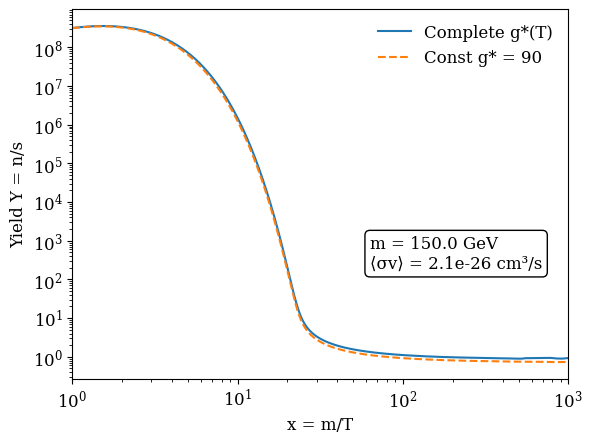

In [ ]:
# Initial condition: start in equilibrium
n_init = n_eq_MB(x_to_T(x_initial))

# Integrate
# ----------------------------
xs = np.geomspace(x_initial, x_final, num_points)

m  = 150.0 #GeV
sigmav_cm3_s = m_sv_interp(m)
print(f"Using <σv> = {sigmav_cm3_s:.2e} cm³/s for m = {m} GeV")
sigmav = sigmav_cm3_s * cm3_s_to_GeVm2
x_final = 1e3


results = evolve(m, sigmav, x_initial, x_final, n_init, xs, t_dep_gstar=True)
sol = results["sol"]
Y_arr = results["Y_arr"]
Omega_h2 = results["Omega_h2"]
Y0 = results["Y0"]
print(f"Relic abundance (full g*): Ωχ h^2 ≈ {Omega_h2:.3f}")

results_const = evolve(m, sigmav, x_initial, x_final, n_init, xs, t_dep_gstar=False)
sol_const = results_const["sol"]
Y_arr_const = results_const["Y_arr"]
Omega_h2_const = results_const["Omega_h2"]
Y0_const = results_const["Y0"]
print(f"Relic abundance (const g*): Ωχ h^2 ≈ {Omega_h2_const:.3f}")

#predicted from Planck resultss (2020)
print("--------")
print(f"Relic abundance from Planck (2020): Ωχ h^2 = 0.120 ± 0.001")


# plot results: x vs n
plt.figure()
plt.plot(sol.t, results["norm_Y_arr"], label='Complete g*(T)')
plt.plot(sol_const.t, results_const["norm_Y_arr"], label='Const g* = 90', linestyle='--')

# add text annotation for m and sigmav
plt.text(0.6, 0.3, f'm = {m} GeV\n⟨σv⟩ = {sigmav_cm3_s:.1e} cm³/s',
         transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

plt.xlabel('x = m/T')
plt.ylabel('Yield Y = n/s')
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlim(1, x_final)
